# Model Behavior
Apply logistic regression. Predict memory recall given alpha, gamma, and exponent changes on a single trial basis.

## Set-up

In [1]:
# Imports - standard
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import ttest_1samp, zscore, linregress
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.metrics import accuracy_score


### Imports

In [2]:
# Imports - custom
import sys
sys.path.append("../code")
from paths import PROJECT_PATH
from info import PATIENTS
from settings import COLORS

### Settings

In [3]:
# set plotting style
plt.style.use("../mplstyle/default.mplstyle")

### Functions

In [4]:
# Ordinal logistic regression helper func

def run_ordered_logit(results, features_x, feature_y):
    """
    Run ordered logistic regression to predict behavior (confidence rating)
    from spectral parameters, for a given subject/channel/material.

    Parameters
    ----------
    results : pandas DataFrame
        Dataframe containing spectral parameters and behavior for each subject.
    features_x : list of str
        Feature names to use for prediction.
    feature_y : str
        Target feature to predict.    

    Returns
    -------
    clf : sklearn LogisticRegression object
        Logistic regression classifier.
    score : float
        Accuracy score for the classifier.
    """

    # get data
    X = results[features_x]
    y = results[feature_y]

    # remove nans
    nan_idx = np.isnan(X).any(axis=1) | np.isnan(y)
    X = X[~nan_idx]
    y = y[~nan_idx]

    # z-score each feature
    for feature in features_x:
        X[feature] = zscore(X[feature])

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # run ordered logistic regression
    model = OrderedModel(y_train, X_train, distr='logit')
    results = model.fit(method='bfgs')

    # predict
    pred_probs = results.predict(X_test)
    pred_categories = np.argmax(pred_probs.values, axis=1) + 1
    score = accuracy_score(y_test, pred_categories)

    return model, results, score



In [5]:
# Binary Logistic regression helper func

def run_logistic_regression(results, features_x, feature_y):
    """
    Run logistic regression to predict behavior from spectral parameters,
    for a given subject/channel/material.

    Parameters
    ----------
    results : pandas DataFrame
        Dataframe containing spectral parameters and behavior for each subject.
    features_x : list of str
        Feature names to use for prediction.
    feature_y : str
        Target feature to predict.    

    Returns
    -------
    model : statsmodels Logit object
        Logistic regression model.
    score : float
        Accuracy score for the classifier.
    """

    # get data
    X = results[features_x]
    y = results[feature_y]

    # remove nans
    nan_idx = np.isnan(X).any(axis=1) | np.isnan(y)
    X = X[~nan_idx]
    y = y[~nan_idx]

    # Add a constant term for the intercept
    X = sm.add_constant(X)

    # z-score each feature
    for feature in features_x:
        X[feature] = zscore(X[feature])

    # run logistic regression
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = sm.Logit(y_train, X_train).fit()
    y_pred_prob = model.predict(X_test)
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)
    score = accuracy_score(y_test, y_pred).astype(float)

    return model, score
    

In [6]:
# Binary Logistic regression with cross-validation helper func

def run_logistic_regression_cv(results, features_x, feature_y):
    """
    Run logistic regression to predict behavior from spectral parameters,
    for a given subject/channel/material, using cross-validation.

    Parameters
    ----------
    results : pandas DataFrame
        Dataframe containing spectral parameters and behavior for each subject.
    features_x : list of str
        Feature names to use for prediction.
    feature_y : str
        Target feature to predict.  

    Returns
    -------
    clf : sklearn LogisticRegression object
        Logistic regression classifier.
    score : float
        Accuracy score for the classifier.
    """

    # get data
    X = results[features_x].to_numpy()
    y = results[feature_y].to_numpy()

    # remove nans
    nan_idx = np.isnan(X).any(axis=1) | np.isnan(y)
    X = X[~nan_idx]
    y = y[~nan_idx]

    # z-score each feature
    X = zscore(X, axis=0)

    # run logistic regression with cross-validation
    clf = LogisticRegression(random_state=0)
    scores = cross_val_score(clf, X, y, cv=5)
    score = scores.mean()

    return clf, score



In [7]:
# plotting functions

def plot_score(df, chance=0.5):
    # plot scores by material
    _, ax = plt.subplots(figsize=[6,4])
    bin_edges = np.arange(0, 1.1, 0.1)
    ax.hist(df.loc[df['material']=='words', 'score'], bin_edges, alpha=0.5, label='word-encoding')
    ax.hist(df.loc[df['material']=='faces', 'score'], bin_edges, alpha=0.5, label='face-encoding')
    # ax.axvline(0.5, color='k', linestyle='--')
    ax.axvline(chance, color='k', linestyle='--')
    ax.set(xlabel='score', ylabel='count')
    ax.set_title("logistic regression scores")
    ax.legend()
    plt.show()

    # plot scores by patient and material
    _, ax = plt.subplots(1, 2, figsize=[12, 4])
    for ax, material in zip(ax, ['words', 'faces']):
        for i_patient, patient in enumerate(PATIENTS):
            ax.hist(df.loc[(df['patient']==patient) & (df['material']==material), 'score'], bin_edges, alpha=0.5, color=f'C{i_patient}')
            ax.axvline(df.loc[(df['patient']==patient) & (df['material']==material), 'score'].mean(), color=f'C{i_patient}', linestyle='--')
        ax.set(xlabel='score', ylabel='count', title=material)
        ax.axvline(chance, color='k', linestyle='--')
    plt.show()

    # print mean scores
    print(f"mean score:\t\t {df['score'].mean():0.3f}")
    print(f"\nmean word score:\t {df.loc[df['material']=='words', 'score'].mean():0.3f}")
    print(f"median word score:\t {df.loc[df['material']=='words', 'score'].median():0.3f}")
    print(f"\nmean face score:\t {df.loc[df['material']=='faces', 'score'].mean():0.3f}")
    print(f"median face score:\t {df.loc[df['material']=='faces', 'score'].median():0.3f}")


## Main

### load data
* load single-trial spectral parameterization results
* load behavioral metadata
* merge

In [221]:
# load single trial spectral parameter results (pipeline step 7)
df = pd.read_csv(f"{PROJECT_PATH}/data/results/psd_trial_params.csv")
df = df.loc[df['ap_mode']=='knee']
df = df.pivot_table(index=["patient", "material", "memory", "chan_idx", "trial", "ap_mode"], columns="epoch", values=["exponent", "alpha", "alpha_adj", "gamma", "gamma_adj"])
for feature in ["exponent", "alpha", "alpha_adj", "gamma", "gamma_adj"]:
    df[(feature, "diff")] = df[(feature, 'post')] - df[(feature, 'pre')]
    df.drop(columns=[(feature, 'pre'), (feature, 'post')], inplace=True)
df.columns = [f"{feature}_{epoch}" for feature, epoch in df.columns]
df.reset_index(inplace=True)
df


,patient,material,memory,chan_idx,trial,ap_mode,exponent_diff,alpha_diff,alpha_adj_diff,gamma_diff,gamma_adj_diff
0,pat02,faces,hit,0,0,knee,-0.280652,-0.855951,0.083597,0.179730,0.093171
1,pat02,faces,hit,0,1,knee,-0.600298,-0.070887,-0.622478,-0.165154,-0.397404
2,pat02,faces,hit,0,2,knee,-0.733306,-0.524995,-1.042180,-0.331322,-0.369544
3,pat02,faces,hit,0,3,knee,-0.599469,-0.729456,-0.500067,-0.289135,-0.406393
4,pat02,faces,hit,0,4,knee,-0.593692,0.218702,0.253919,0.395320,0.542538
...,...,...,...,...,...,...,...,...,...,...,...
120116,pat22,words,miss,52,37,knee,-0.980521,0.152656,1.091916,0.334325,0.216897
120117,pat22,words,miss,52,38,knee,-0.110150,-0.284207,-0.576163,-0.024598,0.053621
120118,pat22,words,miss,52,39,knee,-0.244728,-0.310829,-0.240995,0.021450,0.225685
120119,pat22,words,miss,52,40,knee,-0.454838,-0.834156,-0.992471,0.339826,0.129002


In [ ]:
# # load single trial spectral parameter results (pipeline step 7)
# results = pd.read_csv(f"{PROJECT_PATH}/data/results/single_trial_params.csv", index_col=0)
# results

In [159]:
# aggregate metadata for all patients (including behavioral data)

# from paths import DATASET_PATH
# sys.path.append("../scripts/pipeline")
# from step1_convert_matlab_to_python import import_epochs

# metadata = []

# dir_input = f"{DATASET_PATH}/iEEG"
# for patient in PATIENTS:
#     for material in ['words', 'faces']:
#         fname = f"{patient}_{material}.mat"
        
#         # display progress
#         print('\n__________Reformatting: %s ____________________\n' %fname)
    
#         # import epoch data
#         epochs = import_epochs(f"{dir_input}/{fname}")

#         metadata_i = epochs.metadata.reset_index()
#         metadata_i.rename(columns={'index' : 'trial'}, inplace=True)
#         f_parts = fname.split('_')
#         metadata_i['patient'] = patient
#         metadata_i['material'] = material
#         metadata.append(metadata_i)

# # combine and save to file
# metadata = pd.concat(metadata).reset_index(drop=True)
# metadata.to_csv(f"{PROJECT_PATH}/data/ieeg_metadata/metadata.csv", index=False)

# load
metadata = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/metadata.csv")
metadata

,trial,trial_num,pleasantness,confidence,recalled,reaction_time,patient,material
0,0,2.0,2.0,4.0,1.0,2287.5,pat02,words
1,1,3.0,5.0,1.0,1.0,2024.6,pat02,words
2,2,4.0,3.0,1.0,1.0,2318.8,pat02,words
3,3,5.0,1.0,1.0,1.0,2036.4,pat02,words
4,4,6.0,2.0,2.0,1.0,2293.0,pat02,words
...,...,...,...,...,...,...,...,...
2578,95,98.0,4.0,4.0,1.0,5394.7,pat22,faces
2579,96,99.0,3.0,4.0,1.0,4244.4,pat22,faces
2580,97,100.0,5.0,6.0,0.0,4177.4,pat22,faces
2581,98,101.0,3.0,1.0,1.0,4663.1,pat22,faces


In [ ]:
# # count the number of times each 'patient' had each 'confidence' rating
# confidence_counts = metadata.groupby(['patient', 'confidence']).size().unstack()
# confidence_counts = confidence_counts.fillna(0)
# confidence_counts = confidence_counts.astype(int).reset_index()
# # confidence_counts = confidence_counts.div(confidence_counts.sum(axis=1), axis=0) * 100 # change to percentage

# # plot the number of times each 'patient' had each 'confidence' rating
# _, ax = plt.subplots(figsize=[8,6])
# sns.heatmap(confidence_counts.set_index('patient'), cmap='hot', ax=ax)
# ax.set_title("confidence ratings")
# plt.show()



In [222]:
# merge results and metadata
# results['material'] = results['material'] + 's'
results = df.merge(metadata, on=['patient', 'material', 'trial'])
results

,patient,material,memory,chan_idx,trial,ap_mode,exponent_diff,alpha_diff,alpha_adj_diff,gamma_diff,gamma_adj_diff,trial_num,pleasantness,confidence,recalled,reaction_time
0,pat02,faces,hit,0,0,knee,-0.280652,-0.855951,0.083597,0.179730,0.093171,2.0,4.0,3.0,1.0,1780.1
1,pat02,faces,hit,1,0,knee,-0.623515,-0.775621,-0.365210,0.088607,-0.015821,2.0,4.0,3.0,1.0,1780.1
2,pat02,faces,hit,2,0,knee,0.355443,-0.376352,0.133336,0.280228,0.121742,2.0,4.0,3.0,1.0,1780.1
3,pat02,faces,hit,3,0,knee,0.392906,-0.322657,0.769261,0.175404,0.019318,2.0,4.0,3.0,1.0,1780.1
4,pat02,faces,hit,4,0,knee,0.035045,-0.011587,0.283636,-0.155675,0.177634,2.0,4.0,3.0,1.0,1780.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120116,pat22,words,miss,48,13,knee,-0.177758,0.348087,-0.404924,0.299301,0.015176,15.0,4.0,3.0,1.0,4546.7
120117,pat22,words,miss,49,13,knee,-0.175726,-0.574301,-0.697220,-0.176918,0.045014,15.0,4.0,3.0,1.0,4546.7
120118,pat22,words,miss,50,13,knee,0.387098,-0.331536,0.221241,0.178061,0.113799,15.0,4.0,3.0,1.0,4546.7
120119,pat22,words,miss,51,13,knee,-0.807495,0.135296,-0.172334,0.082981,0.072867,15.0,4.0,3.0,1.0,4546.7


### Run regression
Regress behavior on spectral features
* Ordered/ordinal logistic regression (1-6 confidence rating)
* Binary logistic regression (binary remembered/forgotten)
* Binary logistic regression with cross-validation

#### Ordered logistic regression
regress behavior (confidence rating, 1-6) on spectral parameters 

In [82]:
# # run ordered logistic regression for all channels in each trial condition

# features_x = ['exponent_diff', 'alpha_diff', 'gamma_diff']

# # create dataframe to store results (one row for each channel-material pair)
# df = pd.DataFrame(columns=['patient', 'material', 'channel', 'exp_coef', 
#                            'alpha_coef', 'gamma_coef', 'exp_pval',
#                             'alpha_pval', 'gamma_pval', 'score'])

# # run logistic regression 
# for i_patient, patient in enumerate(PATIENTS):
#     print(f"patient {patient}")
#     channels = results.loc[results['patient']==patient, 'channel'].unique()
#     for channel in channels:
#         for i_material, material in enumerate(['words', 'faces']):
#             try: # some patients/channels don't have data 
#                 res_i = results.loc[(results['patient']==patient) & \
#                                     (results['channel']==channel) & \
#                                     (results['material']==material)]
#                 model, res, score = run_ordered_logit(res_i, features_x, 'confidence')
#                 df_i = pd.DataFrame({'patient' : patient,
#                                     'material' : material,
#                                     'channel' : channel,
#                                     'exp_coef' : res.params[0],
#                                     'alpha_coef' : res.params[1],
#                                     'gamma_coef' : res.params[2],
#                                     'exp_pval' : res.pvalues[0],
#                                     'alpha_pval' : res.pvalues[1],
#                                     'gamma_pval' : res.pvalues[2],
#                                     'score' : score},
#                                     index=[0])
#                 df = pd.concat([df, df_i], axis=0)
#             except:
#                 pass

# df

In [119]:
# save/load results from above
# df.to_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv")
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv", index_col=0)
df

,patient,material,channel,exp_coef,alpha_coef,gamma_coef,exp_pval,alpha_pval,gamma_pval,score
0,pat02,words,0,-0.129770,-0.172075,0.239611,0.603971,0.504283,0.400444,0.437500
0,pat02,faces,0,0.071558,-0.401488,0.092447,0.769362,0.138659,0.695701,0.266667
0,pat02,words,1,0.000566,-0.240599,0.157112,0.998261,0.372296,0.508792,0.500000
0,pat02,faces,1,-0.083954,-0.095937,-0.013100,0.736707,0.696036,0.960470,0.235294
0,pat02,words,2,0.335147,-0.098831,0.240329,0.219324,0.704340,0.300629,0.578947
...,...,...,...,...,...,...,...,...,...,...
0,pat22,faces,50,0.058388,-0.451844,0.062501,0.782027,0.040272,0.793159,0.388889
0,pat22,words,51,0.081518,-0.147457,-0.226853,0.708350,0.476893,0.367455,0.300000
0,pat22,faces,51,-0.230905,-0.341178,-0.159120,0.337599,0.159110,0.508087,0.111111
0,pat22,words,52,0.157200,-0.103951,-0.088706,0.462978,0.625515,0.694986,0.350000


#### Logistic regression (binary)
regress behavior (binarized memory performance) on spectral parameters

In [92]:
# # run logistic regression for all channels in each trial condition

# features_x = ['exponent_diff', 'alpha_diff', 'gamma_diff']
# feature_y = 'recalled'

# # create dataframe to store results (one row for each channel-material pair)
# df = pd.DataFrame(columns=['patient', 'material', 'channel', 'exp_coef', 
#                            'alpha_coef', 'gamma_coef', 'score'])

# # run logistic regression 
# for i_patient, patient in enumerate(PATIENTS):
#     print(f"patient {patient}")
#     channels = results.loc[results['patient']==patient, 'channel'].unique()
#     for channel in channels:
#         for i_material, material in enumerate(['words', 'faces']):
#             try: # some patients/channels don't have data 
#                 res_i = results.loc[(results['patient']==patient) & \
#                                     (results['channel']==channel) & \
#                                     (results['material']==material)]
#                 model, score = run_logistic_regression(res_i, features_x, feature_y)
#                 df_i = pd.DataFrame({'patient' : patient,
#                                     'material' : material,
#                                     'channel' : channel,
#                                     'exp_coef' : model.params[1],
#                                     'alpha_coef' : model.params[2],
#                                     'gamma_coef' : model.params[3],
#                                     'exp_pval' : model.pvalues[1],
#                                     'alpha_pval' : model.pvalues[2],
#                                     'gamma_pval' : model.pvalues[3],
#                                     'score' : score},
#                                     index=[0])
#                 df = pd.concat([df, df_i], axis=0)
#             except:
#                 pass

# df

In [91]:
# save/load results from above
# df.to_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv")
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv", index_col=0)
df

,patient,material,channel,exp_coef,alpha_coef,gamma_coef,score,exp_pval,alpha_pval,gamma_pval
0,pat02,words,0,0.159767,0.123319,-0.052645,0.750000,0.681483,0.763623,0.882424
0,pat02,faces,0,0.015558,0.172531,-0.408147,0.533333,0.958836,0.565088,0.151603
0,pat02,words,1,-0.165237,0.519368,-0.441658,0.812500,0.697154,0.146394,0.264453
0,pat02,faces,1,0.347902,-0.038104,0.030324,0.647059,0.297169,0.894822,0.920474
0,pat02,words,2,-0.039898,0.241246,-0.146025,0.842105,0.917557,0.507345,0.681058
...,...,...,...,...,...,...,...,...,...,...
0,pat22,faces,50,-0.017155,0.521144,-0.185172,0.555556,0.945154,0.056113,0.521689
0,pat22,words,51,-0.452506,0.444754,0.199417,0.400000,0.105783,0.101762,0.477083
0,pat22,faces,51,0.015160,-0.043189,-0.011955,0.388889,0.956653,0.874387,0.964526
0,pat22,words,52,-0.264309,0.186572,0.131709,0.600000,0.304054,0.440744,0.617767


#### Logistic regression (binary) with cross-validation
regress behavior (binarized memory performance) on spectral parameters

In [288]:
# # run logistic regression for all channels in each trial condition

# features_x = ['exponent_diff', 'alpha_diff', 'gamma_diff']
# feature_y = 'recalled'

# # create dataframe to store results (one row for each channel-material pair)
# df = results.groupby(['patient', 'chan_idx', 'material']).count().reset_index()
# df = df[['patient', 'chan_idx', 'material']]
# df['score'] = np.nan 

# # run logistic regression 
# for i_patient, patient in enumerate(PATIENTS):
#     print(f"patient {patient}")
#     channels = results.loc[results['patient']==patient, 'chan_idx'].unique()
#     for channel in channels:
#         for i_material, material in enumerate(['words', 'faces']):
#             try: # some patients/channels don't have data
#                 res_i = results.loc[(results['patient']==patient) & \
#                                     (results['chan_idx']==channel) & \
#                                     (results['material']==material)]
#                 _, score = run_logistic_regression_cv(res_i, features_x, 
#                                                         feature_y)
#                 df_index = (df['patient']==patient) & (df['chan_idx']==channel) & (df['material']==material)
#                 df.loc[df_index, 'score'] = score
#             except:
#                 pass

# df

In [4]:
# save/load results
# df.to_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv.csv")
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv.csv", index_col=0)
df

,patient,chan_idx,material,score
0,pat02,0,faces,0.666667
1,pat02,0,words,0.833333
2,pat02,1,faces,0.679412
3,pat02,1,words,0.837500
4,pat02,2,faces,0.618713
...,...,...,...,...
1338,pat22,50,words,0.473684
1339,pat22,51,faces,0.533987
1340,pat22,51,words,0.489474
1341,pat22,52,faces,0.593464


### Plot regression results

In [144]:
# set chance level (0.5 for binary classification, 1/6 for 6-class classification)
chance = 0.5

In [98]:
# convert score to float
df['score'] = df['score'].astype(float)

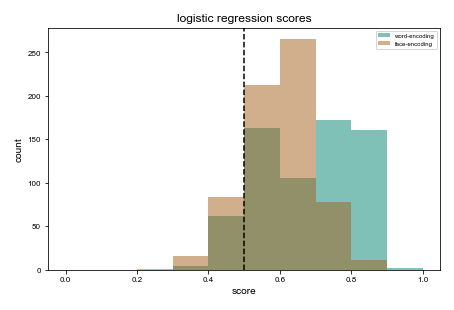

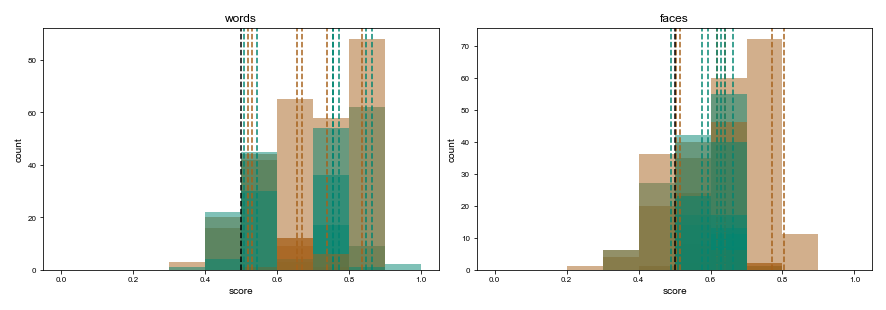

mean score:		 0.642

mean word score:	 0.682
median word score:	 0.702

mean face score:	 0.603
median face score:	 0.608


In [169]:
# plot score and print average scores
plot_score(df, chance=chance)

In [115]:
# # plot histogram of coefficients

# # get those with scores above chance
# df_plt = df.loc[df['score']>(0.7)]
# # df_plt = df.copy()

# # plot
# all_values = df_plt[['exponent_coef', 'alpha_coef', 'gamma_coef']].values.flatten()
# bins = np.linspace(np.min(all_values), np.max(all_values), 30)
# _, ax = plt.subplots(1, 3, figsize=[12, 4], sharey=True, constrained_layout=True)
# for i, feature in enumerate(['exp_coef', 'alpha_coef', 'gamma_coef']):
#     ax[i].hist(df_plt[feature], bins, color=COLORS['blue'])
#     ax[i].set(xlabel=feature, ylabel='count')
#     ax[i].axvline(0, color='k', linestyle='--') 
# plt.show()


# # plot
# all_values = df_plt[['exponent_coef', 'alpha_coef', 'gamma_coef']].values.flatten()
# bins = np.linspace(np.min(all_values), np.max(all_values), 30)
# _, ax = plt.subplots(figsize=[6, 4])
# for i, feature in enumerate(['exp_coef', 'alpha_coef', 'gamma_coef']):
#     ax.hist(df_plt[feature], bins, alpha=0.5, label=feature)
# ax.axvline(0, color='k', linestyle='--')
# ax.set(xlabel='coefficient', ylabel='count')
# ax.legend()
# plt.show()


In [117]:
# # plot histogram of pvalues

# # get those with scores above chance
# # df_plt = df.loc[df['score']>(1/6)]
# df_plt = df.copy()

# # plot
# _, ax = plt.subplots(1, 3, figsize=[12, 4], sharey=True, constrained_layout=True)
# for i, feature in enumerate(['exp_pval', 'alpha_pval', 'gamma_pval']):
#     ax[i].hist(df_plt[feature])
#     ax[i].set(xlabel=feature, ylabel='count')
# plt.show()


### Analyze coefficients and p-values
Run stats and create figures for manuscript

In [ ]:
# run 1-smaple t-test to determine if coefficients are significantly different from 0

# print coefficients
print(f"Mean coefficients:")
print(f"exp:\t {df['exp_coef'].mean():0.5f}")
print(f"alpha:\t {df['alpha_coef'].mean():0.5f}")
print(f"gamma:\t {df['gamma_coef'].mean():0.5f}")

# run 1 sample t-test
print("\n\nT-test results:")
for ii in range(3):
    data_i = df.iloc[:,ii+3].to_numpy()
    t, p = ttest_1samp(data_i, 0)
    print(f"{df.columns[ii+3].split('_')[0]}:\t t={t:0.3f}, p={p:0.3f}")
    
# run 1 sample t-test for word-/face-encoding only
for material in ['words', 'faces']:
    print(f"\n\nT-test, {material}-encoding:")
    df_m = df.loc[df['material']==material] # subset dataframe
    for ii in range(3):
        data_i = df_m.iloc[:,ii+3]
        t, p = ttest_1samp(data_i, 0)
        print(f"{df.columns[ii+3].split('_')[0]}:\t t={t:0.3f}, p={p:0.3f}")

In [ ]:
# analyze coefficients for predictive channels only

def analyze_coef(df):
    """
    Evaluate whether logistic regression coefficients are significantly different
    than zero. Print results of 1-sample t-test.
    """

    for material in ['words', 'faces']:
        print(f"\nT-test, {material}-encoding:")
        for ii in range(3):
            df_m = df.loc[df['material']==material]
            data_i = df_m.iloc[:,ii+3]
            t, p = ttest_1samp(data_i, 0)
            print(f"{df.columns[ii+3].split('_')[0]}:\t t={t:0.5f}, p={p:0.5f}")

# test 
for threshold in np.linspace(0.1,0.9,9):
    print(f"\n\nThreshold = {threshold} ********************")
    df_i = df.loc[df['score'] > threshold]
    analyze_coef(df_i)

In [ ]:
# count number of signifcant coefficients for each feature
alpha = 0.05
for feature in ['exp', 'alpha', 'gamma']:
    n_sig = np.sum(df[f'{feature}_pval']<alpha)
    print(f"{feature}:\t{n_sig} ({n_sig/len(df)*100:0.2f}%)")


These results suggest that modulation of the aperiodic exponent on a single-trial basis is predictive of memory recall for word-encoding trials but not for face-eencoding trials. 

In [ ]:
# plot violin plot of regression scores

# set plotting params
plotting_params = {
    'data'  :   df,
    'x'     :   'material',
    'y'     :   'score',
}

# plot
_, ax = plt.subplots(figsize=[4,3])
sns.violinplot(**plotting_params, ax=ax, color=COLORS['blue'])
ax.axhline(chance, color='k', linestyle='--')

# add significance markers
for i_material, material in enumerate(['words', 'faces']):
# for i_material, material in enumerate(['words', 'faces']):
    data = df.loc[df['material']==material, 'score']
    data = data[~np.isnan(data)]
    t, p = ttest_1samp(data, chance)
    if p < 0.05:
        ax.text(i_material, np.max(df['score'])*1.15, '*', fontsize=12, ha='center', va='center')

    # print stats
    print(f"\nT-test, {material}-encoding:")
    print(f"t={t:0.3f}, p={p:0.3n}")

ax.set_ylim([np.min(df['score'])-np.min(df['score'])*0.3, np.max(df['score'])*1.3])
ax.set(ylabel='regression score')
plt.show()

#### plot score v. electrode coordinate

In [6]:
# fname = r"C:\Users\micha\projects\oscillation_vs_exponent\data\specparam_sensitivity_analysis\logit_scores\psd_trial_params_7.csv"
# df = pd.read_csv(fname, index_col=0)
# df = df.loc[df['ap_mode']=='knee'].drop(columns='ap_mode')
# df.rename(columns={'channel':'chan_idx'}, inplace=True)
# df

In [7]:
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv_.csv", index_col=0)
df = df[['patient', 'chan_idx', 'material', 'score']]
df

,patient,chan_idx,material,score
0,pat02,0,faces,0.616989
1,pat02,0,words,0.787500
2,pat02,1,faces,0.644563
3,pat02,1,words,0.792803
4,pat02,2,faces,0.665149
...,...,...,...,...
1338,pat22,50,words,0.514845
1339,pat22,51,faces,0.582017
1340,pat22,51,words,0.500385
1341,pat22,52,faces,0.610420


In [8]:
# load regression results from above
# results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv", index_col=0)
# results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv.csv", index_col=0)
# results = pd.read_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv", index_col=0)
# results.rename(columns={'channel':'chan_idx'}, inplace=True)

# load electrode locations
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)

# merge channel info with regression results
# df.rename(columns={'channel':'chan_idx'}, inplace=True)
df = pd.merge(df, df_elec, on=['patient', 'chan_idx'])
df

,patient,chan_idx,material,score,label,pos_y,pos_x,pos_z
0,pat02,0,faces,0.616989,A01-A02,-65.43100,61.94490,3.55955
1,pat02,0,words,0.787500,A01-A02,-65.43100,61.94490,3.55955
2,pat02,1,faces,0.644563,A02-A03,-70.93895,57.17765,12.15540
3,pat02,1,words,0.792803,A02-A03,-70.93895,57.17765,12.15540
4,pat02,2,faces,0.665149,A03-A04,-75.39550,51.39440,20.94335
...,...,...,...,...,...,...,...,...
1338,pat22,50,words,0.514845,MOF_07-MOF_08,44.50000,-14.00000,16.50000
1339,pat22,51,faces,0.582017,MOF_08-MOF_09,48.00000,-14.00000,23.50000
1340,pat22,51,words,0.500385,MOF_08-MOF_09,48.00000,-14.00000,23.50000
1341,pat22,52,faces,0.610420,MOF_09-MOF_10,52.00000,-14.00000,30.00000


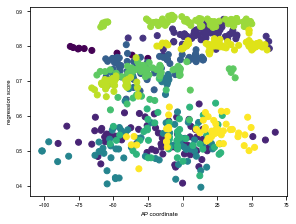

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score    
No. Observations: 668     Method:             REML     
No. Groups:       13      Scale:              0.0009   
Min. group size:  9       Log-Likelihood:     1340.5296
Max. group size:  88      Converged:          Yes      
Mean group size:  51.4                                 
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
const         0.690    0.034 20.450 0.000  0.624  0.756
pos_y         0.000    0.000  1.211 0.226 -0.000  0.000
Group Var     0.015    0.203                           

coef:	 5.679248657260086e-05


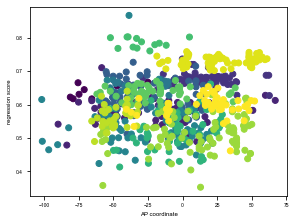

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score    
No. Observations: 669     Method:             REML     
No. Groups:       13      Scale:              0.0017   
Min. group size:  9       Log-Likelihood:     1138.4344
Max. group size:  88      Converged:          Yes      
Mean group size:  51.5                                 
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
const         0.620    0.022 27.645 0.000  0.576  0.664
pos_y         0.000    0.000  1.486 0.137 -0.000  0.000
Group Var     0.006    0.065                           

coef:	 9.56575014546238e-05


c:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


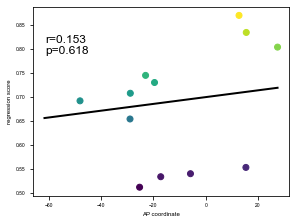

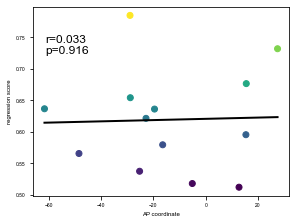

In [9]:
# compute correlation between score and position - LMM - color by patient
from statsmodels.regression.mixed_linear_model import MixedLM

for material in ['words', 'faces']:
    # drop NaN
    df_c = df.dropna()
    df_c = df_c.loc[df_c['material']==material]
    x_data = df_c['pos_y']
    y_data = df_c['score']

    # convert 'patient' for color plotting
    # take end of string and convert to int
    df_c['patient'] = df_c['patient'].str[3:].astype(int)
    color = df_c['patient']

    # plot data
    fig, ax = plt.subplots(figsize=[4,3])
    ax.scatter(x_data, y_data, c=color)
    ax.set(xlabel=f"AP coordinate", ylabel="regression score")
    plt.show()

    # run LMM
    model = MixedLM(y_data, sm.add_constant(x_data), df_c['patient'])
    results = model.fit()
    print(results.summary())

    # print coefficient for position
    print(f"coef:\t {results.params[1]}")


# Now, average scores within patient and re-run summary stats
df_avg = df.groupby(['patient', 'material']).mean().reset_index()

for material in ['words', 'faces']:
    # drop NaN
    df_c = df_avg.dropna()
    df_c = df_c.loc[df_c['material']==material]
    x_data = df_c['pos_y']
    y_data = df_c['score']

    # run regression
    stats = linregress(x_data, y_data)
    t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
    lin = stats.slope * t_lin + stats.intercept

    # plot results
    fig, ax = plt.subplots(figsize=[4,3])
    ax.scatter(x_data, y_data, c=y_data, cmap='viridis')
    ax.plot(t_lin, lin, color='k', linewidth=2)
    ax.text(0.05, 0.75, f"r={stats.rvalue:0.3f}\np={stats.pvalue:0.3f}",
            transform=ax.transAxes, backgroundcolor='w', fontsize=12)
    ax.set(xlabel=f"AP coordinate", ylabel="regression score")
    plt.show()
    


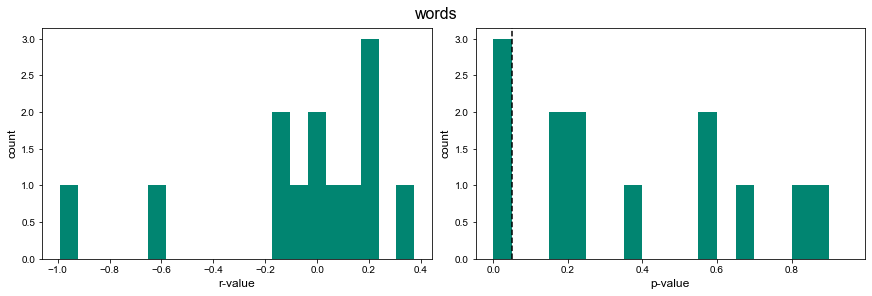

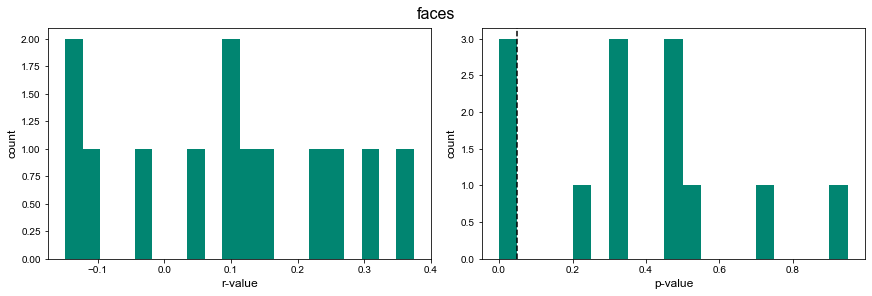

,patient,material,rvalue,pvalue
0,pat02,words,-0.991449,1.887800e-07
1,pat02,faces,0.264700,4.912585e-01
2,pat04,words,-0.145091,2.307549e-01
3,pat04,faces,0.089604,4.607150e-01
4,pat05,words,0.177670,1.601550e-01
5,pat05,faces,-0.130948,3.023595e-01
6,pat08,words,0.373773,1.436192e-03
7,pat08,faces,-0.120593,3.200172e-01
8,pat10,words,-0.616712,8.368265e-03
9,pat10,faces,0.160681,5.378509e-01


In [35]:
# model regression for each patient

df_list = []
for patient in PATIENTS:
    for material in ['words', 'faces']:
        # get data for patient/material and drop NaN
        df_m = df.loc[(df['material']==material) & (df['patient']==patient)]
        df_m = df_m.dropna()
        x_data = df_m['pos_y']
        y_data = df_m['score']

        # run regression
        stats = linregress(x_data, y_data)

        # aggregate results
        df_i = pd.DataFrame({'patient' : patient,
                            'material' : material,
                            'rvalue' : stats.rvalue,
                            'pvalue' : stats.pvalue},
                            index=[0])
        df_list.append(df_i)

# combine results
df_results = pd.concat(df_list).reset_index(drop=True)

# plot
p_bins = np.arange(0, 1, 0.05)
for material in ['words', 'faces']:
    df_m = df_results.loc[df_results['material']==material]
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[12,4])
    fig.suptitle(material, fontsize=16)
    ax0.hist(df_m['rvalue'], bins=20, color=COLORS['blue'])
    ax0.set_xlabel("r-value", fontsize=12)
    ax0.set_ylabel("count", fontsize=12)
    ax1.hist(df_m['pvalue'], bins=p_bins, color=COLORS['blue'])
    ax1.set_xlabel("p-value", fontsize=12)
    ax1.set_ylabel("count", fontsize=12)
    ax1.axvline(0.05, color='k', linestyle='--')
    for ax in [ax0, ax1]:
        ax.tick_params(axis='both', which='major', labelsize=10)
    plt.show()

# print results
df_results


In [36]:
from scipy.stats import ttest_1samp

# run 1-sample t-test for r-values
for material in ['words', 'faces']:
    df_m = df_results.loc[df_results['material']==material]
    t, p = ttest_1samp(df_m['rvalue'], 0)
    print(f"{material}:\t t={t:0.3f}, p={p:0.3f}")

# drop outliers and re-run
outlier_idx = [0, 8]
df_results_no = df_results.drop(outlier_idx)
print("\n\nAfter dropping outliers:")
for material in ['words', 'faces']:
    df_m = df_results_no.loc[df_results_no['material']==material]
    t, p = ttest_1samp(df_m['rvalue'], 0)
    print(f"{material}:\t t={t:0.3f}, p={p:0.3f}")

words:	 t=-0.591, p=0.565
faces:	 t=2.063, p=0.061


After dropping outliers:
words:	 t=1.588, p=0.143
faces:	 t=2.063, p=0.061


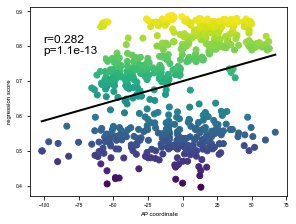

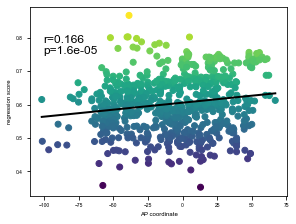

In [11]:
# compute correlation between score and position

for material in ['words', 'faces']:
    # drop NaN
    df_c = df.dropna()
    df_c = df_c.loc[df_c['material']==material]
    x_data = df_c['pos_y']
    y_data = df_c['score']

    # run regression and plot results
    stats = linregress(x_data, y_data)
    t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
    lin = stats.slope * t_lin + stats.intercept

    # plot
    fig, ax = plt.subplots(figsize=[4,3])
    ax.scatter(x_data, y_data, c=y_data, cmap='viridis')
    ax.plot(t_lin, lin, color='k', linewidth=2)
    ax.text(0.05, 0.75, f"r={stats.rvalue:0.3f}\np={stats.pvalue:0.1e}",
            transform=ax.transAxes, backgroundcolor='w', fontsize=12)
    ax.set(xlabel=f"AP coordinate", ylabel="regression score")
    plt.show()

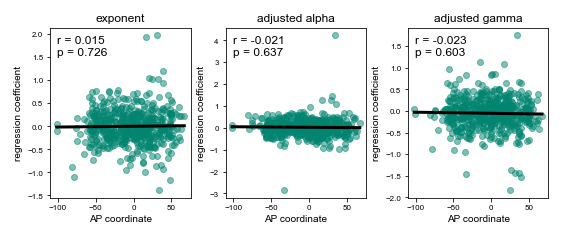

In [152]:
# compute correlation between coeeficient and position

material = 'words'

# load regression results (with coefficients - not cross-validated)
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv", index_col=0)
# results = pd.read_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv", index_col=0)
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)
df_elec.rename(columns={'chan_idx':'channel'}, inplace=True)
df_plt = pd.merge(results, df_elec, on=['patient', 'channel'])

# get those with scores above chance
df_plt = df_plt.loc[df_plt['score']>(0.5)]

# drop NaN
df_c = df_plt.dropna()
df_c = df_c.loc[df_c['material']==material]
x_data = df_c['pos_y']

# create fig
fig, axes = plt.subplots(1, 3, figsize=[7.5, 3], constrained_layout=True)
titles = ['exponent', 'adjusted alpha', 'adjusted gamma']
for ax, feature, title in zip(axes, ['exp', 'alpha', 'gamma'], titles):
        y_data = df_c[f'{feature}_coef']

        # plot data
        ax.set_title(title)
        ax.scatter(x_data, y_data, color=COLORS['blue'], alpha=0.5)
        ax.set(xlabel=f"AP coordinate", ylabel="regression coefficient")

        # run regression and plot results
        stats = linregress(x_data, y_data)
        t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
        lin = stats.slope * t_lin + stats.intercept
        
        ax.plot(t_lin, lin, color='k', linewidth=3)
        if stats.pvalue > 0.01:
                ax.text(0.05, 0.84, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.3n}", 
                        transform=ax.transAxes, backgroundcolor='w', fontsize=12)
        else:
                ax.text(0.05, 0.84, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.1e}", 
                        transform=ax.transAxes, backgroundcolor='w', fontsize=12)

plt.show()

#### combine figures for manuscript

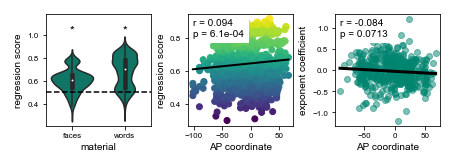

In [79]:
# manuscript figure

material = 'words'

# init
fig, (ax_b, ax_c, ax_d) = plt.subplots(1, 3, figsize=[6, 2], constrained_layout=True)

# B. plot violin plot of regression scores =====================================
# set plotting params
plotting_params = {
    'data'  :   df,
    'x'     :   'material',
    'y'     :   'score',
}

# plot
sns.violinplot(**plotting_params, ax=ax_b, color=COLORS['blue'])
ax_b.axhline(chance, color='k', linestyle='--')
ax_b.set_ylim([np.min(df['score'])-np.min(df['score'])*0.3, np.max(df['score'])*1.3])
ax_b.set(ylabel='regression score')

# add significance markers
for i_material, material in enumerate(['words', 'faces']):
    data = df.loc[df['material']==material, 'score']
    data = data[~np.isnan(data)]
    t, p = ttest_1samp(data, chance)
    if p < 0.05:
        ax_b.text(i_material, np.max(df['score'])*1.15, '*', fontsize=12, ha='center', va='center')

# C. scatter plot: correlate regresion score and AP coordinate =================

# drop NaN
df_c = df.dropna()
df_c = df_c.loc[df_c['material']==material]
x_data = df_c['pos_y']
y_data = df_c['score']

# plot data
ax_c.scatter(x_data, y_data, c=y_data, cmap='viridis')
ax_c.set(xlabel=f"AP coordinate", ylabel="regression score")

# run regression and plot results
stats = linregress(x_data, y_data)
t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
lin = stats.slope * t_lin + stats.intercept
ax_c.plot(t_lin, lin, color='k', linewidth=2)
ax_c.text(0.05, 0.8, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.1e}",
        transform=ax_c.transAxes, backgroundcolor='w')


# D. scatter plot: correlate exponent coeeficient and AP coordinate ============
# load regression results (with coefficients - not cross-validated)
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv", index_col=0)
results = results.loc[results['material']==material]
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)
df_elec.rename(columns={'chan_idx':'channel'}, inplace=True)
df_plt = pd.merge(results, df_elec, on=['patient', 'channel'])

# get those with scores above chance
df_plt = df_plt.loc[df_plt['score']>(0.5)]

# drop NaN
df_c = df_plt.dropna()
x_data = df_c['pos_y']
y_data = df_c['exp_coef']

# plot data
ax_d.scatter(x_data, y_data, color=COLORS['blue'], alpha=0.5)
ax_d.set(xlabel=f"AP coordinate", ylabel="exponent coefficient")

# run regression and plot results
stats = linregress(x_data, y_data)
t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
lin = stats.slope * t_lin + stats.intercept
ax_d.plot(t_lin, lin, color='k', linewidth=3)
if stats.pvalue > 0.01:
        ax_d.text(0.05, 0.8, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.3n}", 
                transform=ax_d.transAxes, backgroundcolor='w')
else:
        ax_d.text(0.05, 0.8, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.1e}", 
                transform=ax_d.transAxes, backgroundcolor='w')

# save fig
# plt.savefig(f"{PROJECT_PATH}/figures/main_figures/model_behavior_bcd.png")


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



T-test, words-encoding:
mean score:	0.682
t=34.564, p=8.4e-151

T-test, faces-encoding:
mean score:	0.603
t=27.088, p=1.6e-109


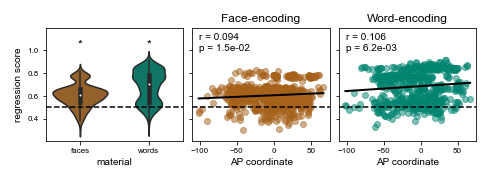

In [215]:
# manuscript figure

# init
fig, (ax_b, ax_c, ax_d) = plt.subplots(1, 3, figsize=[6.5, 2.2], sharey=True,
                                 constrained_layout=True)


# B. plot violin plot of regression scores =====================================
# set plotting params
plotting_params = {
    'data'  :   df,
    'x'     :   'material',
    'y'     :   'score',
}

# plot
sns.violinplot(**plotting_params, ax=ax_b, palette=[COLORS['brown'], COLORS['blue']])
ax_b.set_ylim([np.min(df['score'])-np.min(df['score'])*0.3, np.max(df['score'])*1.3])
ax_b.set(ylabel='regression score')

# add significance markers
for i_material, material in enumerate(['words', 'faces']):
    data = df.loc[df['material']==material, 'score']
    data = data[~np.isnan(data)]
    t, p = ttest_1samp(data, chance)
    if p < 0.05:
        ax_b.text(i_material, np.max(df['score'])*1.15, '*', fontsize=12, ha='center', va='center')

    # print stats
    print(f"\nT-test, {material}-encoding:")
    print(f"mean score:\t{np.nanmean(data):0.3f}")
    print(f"t={t:0.3f}, p={p:0.1e}")

# C. scatter plot: correlate regresion score and AP coordinate =================

# drop NaN
df_c = df.dropna()
df_c = df_c.loc[df_c['material']=='faces']
x_data = df_c['pos_y']
y_data = df_c['score']

# plot data
ax_c.scatter(x_data, y_data, c=COLORS['brown'], alpha=0.5)
ax_c.set(xlabel=f"AP coordinate")#, ylabel="regression score")
ax_c.set_title("Face-encoding")

# run regression and plot results
stats = linregress(x_data, y_data)
t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
lin = stats.slope * t_lin + stats.intercept
ax_c.plot(t_lin, lin, color='k', linewidth=2)
ax_c.text(0.05, 0.8, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.1e}",
        transform=ax_c.transAxes)

# D. scatter plot: correlate regresion score and AP coordinate =================

# drop NaN
df_c = df.dropna()
df_c = df_c.loc[df_c['material']=='words']
x_data = df_c['pos_y']
y_data = df_c['score']

# plot data
ax_d.scatter(x_data, y_data, c=COLORS['blue'], alpha=0.5)
ax_d.set(xlabel=f"AP coordinate")#, ylabel="regression score")
ax_d.set_title("Word-encoding")

# run regression and plot results
stats = linregress(x_data, y_data)
t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
lin = stats.slope * t_lin + stats.intercept
ax_d.plot(t_lin, lin, color='k', linewidth=2)
ax_d.text(0.05, 0.8, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.1e}",
        transform=ax_d.transAxes)

# add chance line
for ax in [ax_b, ax_c, ax_d]:
    ax.axhline(chance, color='k', linestyle='--')

# save fig
plt.savefig(f"{PROJECT_PATH}/figures/main_figures/model_behavior_bcd.png")


Scores follow cognitive hierarchy, with more frontal channels better predicticting memory behavior

### Plot topography of regression results - PyVista

switch to pyvista environment

#### imports

In [ ]:
# imports

# general
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# local
import sys
sys.path.append("../code")
from paths import PROJECT_PATH
from plots import plot_data_spatial
from settings import COLORS

In [ ]:
# auto reload
%load_ext autoreload
%autoreload 2

#### load data

In [ ]:
# load regression results from above
# results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv.csv", index_col=0)
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv", index_col=0)

# load electrode locations
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)
df_elec.rename(columns={'chan_idx':'channel'}, inplace=True)

# merge channel info with regression results
df = pd.merge(results, df_elec, on=['patient', 'channel'])

df

### plot topography

In [ ]:
# plot topo map of scores

# loop through materials
for material in ['word', 'face']:

    # get info for trial block 
    df_i = df.loc[df['material']==material]
    df_i = df_i.dropna()
    elec_pos = df_i[['pos_x', 'pos_y', 'pos_z']]

    # split data by hemisphere
    pos = dict()
    score = dict()
    pos['right'] = elec_pos[elec_pos['pos_x'] >= 0].to_numpy()
    score['right'] = df_i.loc[df_i['pos_x'] >= 0, 'score'].to_numpy()
    pos['left'] = elec_pos[elec_pos['pos_x'] < 0].to_numpy()
    score['left'] = df_i.loc[df_i['pos_x'] < 0, 'score'].to_numpy()

    # plot ech hemisphere 
    for hemi in ['right', 'left']:
        for view in ['lateral', 'medial']:
            plot_data_spatial(score[hemi], pos[hemi], hemi, view,
                    cbar_label='regression score')

In [ ]:
# prep data for plotting mean score across materials

# pivot score on material
index =['patient', 'channel', 'pos_x', 'pos_y', 'pos_z']
df_p = df.pivot(index=index, columns='material', values='score')

# compute mean score across materials
df_p['score'] = df_p.mean(axis=1)
df_p.reset_index(inplace=True)
df_p

In [ ]:
# plot mean score across materials

# set output path
path_out = f"{PROJECT_PATH}/figures/behavioral_modeling"
if not os.path.exists(f"{path_out}/temp"):
    os.makedirs(f"{path_out}/temp")

# get info for trial block 
df_i = df_p.dropna()
elec_pos = df_i[['pos_x', 'pos_y', 'pos_z']]

# split data by hemisphere
pos = dict()
score = dict()
pos['right'] = elec_pos[elec_pos['pos_x'] >= 0].to_numpy()
score['right'] = df_i.loc[df_i['pos_x'] >= 0, 'score'].to_numpy()
pos['left'] = elec_pos[elec_pos['pos_x'] < 0].to_numpy()
score['left'] = df_i.loc[df_i['pos_x'] < 0, 'score'].to_numpy()

# plot each hemisphere/view
clim = [np.min(df_p['score']), np.max(df_p['score'])]
for hemi in ['right', 'left']:
    for view in ['lateral', 'medial']:
        fname_out = f"{path_out}/temp/behavioral_modeling_{hemi}_{view}.png"
        plot_data_spatial(score[hemi], pos[hemi], hemi, view, plot_cbar=False,
                          fname_out=fname_out, elec_size=36, clim=clim)
        
# combine hemispheres and views into a single figure and save to file
images = [plt.imread(f"{path_out}/temp/{f}") for f in os.listdir(f"{path_out}/temp")]
image = np.concatenate(images, axis=1)
fig, ax = plt.subplots(1,1, figsize=(20, 10))
ax.imshow(image)
ax.axis('off')
fig.savefig(f"{path_out}/behavioral_modeling.png", bbox_inches='tight')

In [ ]:
# plot an example of the plot above to screenshot the colorbar
plot_data_spatial(score[hemi], pos[hemi], hemi, view, clim=clim)

### Sensitivity analysis
SpecParam hyperparameters (peak width limits, peak threshold, max number of peaks)

In [295]:
# identify/create output path
path_out = f"{PROJECT_PATH}/figures/behavioral_modeling"
if not os.path.exists(path_out):
    os.makedirs(path_out)

In [296]:
# load all scores
dir_input = f"{PROJECT_PATH}/data/specparam_sensitivity_analysis/logit_scores"
files = os.listdir(dir_input)

df_list = []
for fname in files:
    idx = fname.split('_')[-1].split('.')[0]
    df_i = pd.read_csv(f"{dir_input}/{fname}", index_col=0)
    df_i.insert(0, 'idx', idx)
    df_list.append(df_i)

df_score = pd.concat(df_list)
df_score

,idx,patient,channel,material,ap_mode,score
0,0,pat02,0,faces,fixed,0.581667
1,0,pat02,0,faces,knee,0.583333
2,0,pat02,0,words,fixed,0.787500
3,0,pat02,0,words,knee,0.787500
4,0,pat02,1,faces,fixed,0.639706
...,...,...,...,...,...,...
2681,9,pat22,51,words,knee,0.501053
2682,9,pat22,52,faces,fixed,0.604575
2683,9,pat22,52,faces,knee,0.592810
2684,9,pat22,52,words,fixed,0.520000


In [297]:
# print indices present

print('Parameters present:')
print(df_score['idx'].unique())

print('\nParameter sets 10 and 11 failed to run. These included low peak thresholds (1 and 2 STDs)')


Parameters present:
['0' '1' '12' '13' '14' '2' '3' '4' '5' '6' '7' '8' '9']

Parameter sets 10 and 11 failed to run. These included low peak thresholds (1 and 2 STDs)


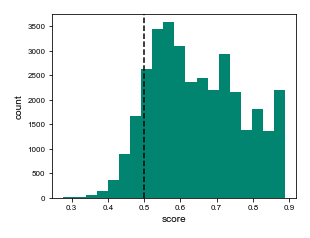

t = 223.382, p = 0.0e+00


In [298]:
# simply plot hist of all scores
_, ax = plt.subplots(figsize=[4,3])
ax.hist(df_score['score'], bins=20, color=COLORS['blue'])
ax.set(xlabel='score', ylabel='count')
ax.axvline(0.5, color='k', linestyle='--')
plt.show()

# one-sample t-test
scores = df_score.dropna()['score']
t, p = ttest_1samp(scores, 0.5)
print(f"t = {t:0.3f}, p = {p:1.1e}")


In [299]:
# load electrode locations and merge with scores

# load electrode locations
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)
df_elec.rename(columns={'chan_idx':'channel'}, inplace=True)

# merge channel info with regression results
df = pd.merge(df_score, df_elec, on=['patient', 'channel'])
df

,idx,patient,channel,material,ap_mode,score,label,pos_y,pos_x,pos_z
0,0,pat02,0,faces,fixed,0.581667,A01-A02,-65.431,61.9449,3.55955
1,0,pat02,0,faces,knee,0.583333,A01-A02,-65.431,61.9449,3.55955
2,0,pat02,0,words,fixed,0.787500,A01-A02,-65.431,61.9449,3.55955
3,0,pat02,0,words,knee,0.787500,A01-A02,-65.431,61.9449,3.55955
4,1,pat02,0,faces,fixed,0.556667,A01-A02,-65.431,61.9449,3.55955
...,...,...,...,...,...,...,...,...,...,...
34913,8,pat22,52,words,knee,0.477895,MOF_09-MOF_10,52.000,-14.0000,30.00000
34914,9,pat22,52,faces,fixed,0.604575,MOF_09-MOF_10,52.000,-14.0000,30.00000
34915,9,pat22,52,faces,knee,0.592810,MOF_09-MOF_10,52.000,-14.0000,30.00000
34916,9,pat22,52,words,fixed,0.520000,MOF_09-MOF_10,52.000,-14.0000,30.00000


In [300]:
# define function to run and collect stats

def analyze_scores(df):
    """
    Perform stats:
        1. Run one-sample t-test: scores v. chance (for each block)
        2. Regress score on AP coordinate
    """

    # init
    df_c = df.dropna()
    results = np.zeros(4)

    # 1. one-sample t-test: scores v. chance
    t, p = ttest_1samp(df_c['score'], 0.5)
    results[0] = t
    results[1] = p

    # 2. regress score on AP coordinate
    regress = linregress(df_c['pos_y'], df_c['score'])
    results[2] = regress.rvalue
    results[3] = regress.pvalue
    
    return results


In [301]:
# run and collect stats

columns=['ttest_t', 'ttest_p', 'regress_r', 'regress_p']
stats_list = []

for material in ['words', 'faces']:
    for idx in df['idx'].unique():
        for ap_mode in ['fixed', 'knee']:
            df_i = df.loc[(df['idx']==idx) & \
                          (df['material']==material) & \
                            (df['ap_mode']==ap_mode)]
            stats_i = analyze_scores(df_i)
            stats_i = pd.DataFrame(stats_i, index=columns).T
            stats_i.insert(0, 'idx', idx)
            stats_i.insert(1, 'material', material)
            stats_i.insert(2, 'ap_mode', ap_mode)
            stats_list.append(stats_i)

df_stats = pd.concat(stats_list)
df_stats


,idx,material,ap_mode,ttest_t,ttest_p,regress_r,regress_p
0,0,words,fixed,36.170808,2.133916e-159,0.280872,1.412797e-13
0,0,words,knee,36.415848,1.071180e-160,0.283674,7.896295e-14
0,1,words,fixed,36.413740,1.099072e-160,0.280354,1.572211e-13
0,1,words,knee,36.453766,6.746266e-161,0.280762,1.445519e-13
0,12,words,fixed,36.723999,2.512028e-162,0.286611,4.259694e-14
0,12,words,knee,36.392762,1.419553e-160,0.280487,1.529766e-13
0,13,words,fixed,36.440722,7.909163e-161,0.279845,1.746019e-13
0,13,words,knee,36.675315,4.541633e-162,0.276292,3.606925e-13
0,14,words,fixed,36.442381,7.750804e-161,0.280602,1.493909e-13
0,14,words,knee,36.725170,2.476512e-162,0.275515,4.221056e-13


In [87]:
# # plot violin plot of ttest stats

# # ttest violin plot 
# fig, ax = plt.subplots(1, 3, figsize=[6.5, 2], constrained_layout=True)
# # fig.suptitle(f"Sensitivity analysis for t-test (score v. chance)")
# fig.suptitle(f"Sensitivity analysis for Fig 9B")

# sns.violinplot(data=df_stats, x='material', y='ttest_t', ax=ax[0], color=COLORS['blue'])
# ax[0].set(ylabel='t-statistic')

# # plot p-values materials separately (for better visualization)
# for i_material, material in enumerate(['words', 'faces']):
#     sns.violinplot(data=df_stats.loc[df_stats['material']==material], y='ttest_p', ax=ax[1+i_material], color=COLORS['blue'])
#     ax[1+i_material].set(xlabel=material, ylabel='p-value')
#     ax[1+i_material].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# # save/show
# plt.savefig(f"{path_out}/sensitivity_analysis_ttest.png")
# plt.show()


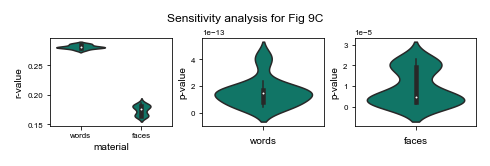

Mean t-statistics:
material
faces    0.174284
words    0.281435
Name: regress_r, dtype: float64

Mean p-values:
material
faces    9.257063e-06
words    1.556775e-13
Name: regress_p, dtype: float64


In [212]:
# plot violin plot of regression stats

# regression violin plot
fig, ax = plt.subplots(1, 3, figsize=[6.5, 2], constrained_layout=True)
# fig.suptitle(f"Sensitivity analysis for regression (score v. coordinate)")
fig.suptitle(f"Sensitivity analysis for Fig 9C")

sns.violinplot(data=df_stats, x='material', y='regress_r', ax=ax[0], color=COLORS['blue'])
ax[0].set(ylabel='r-value')

# plot p-values materials separately (for better visualization)
for i_material, material in enumerate(['words', 'faces']):
    sns.violinplot(data=df_stats.loc[df_stats['material']==material], y='regress_p', ax=ax[1+i_material], color=COLORS['blue'])
    ax[1+i_material].set(xlabel=material, ylabel='p-value')

# save/show
# plt.savefig(f"{path_out}/sensitivity_analysis_regression.png")
plt.show()

# print means
print("Mean t-statistics:")
print(df_stats.groupby('material')['regress_r'].mean())
print("\nMean p-values:")
print(df_stats.groupby('material')['regress_p'].mean())



In [213]:
# run and collect stats - average within patient

# init
t_values = []
p_values = []
materials_ = []
ap_modes_ = []
indices_ = []

# average df over channels within each patient
df_p = df.groupby(['patient', 'material', 'ap_mode', 'idx']).mean().reset_index().drop(columns=['channel', 'pos_x', 'pos_y', 'pos_z'])

# run
for material in ['words', 'faces']:
    for idx in df_p['idx'].unique():
        for ap_mode in ['fixed', 'knee']:
            df_i = df_p.loc[(df_p['idx']==idx) & (df_p['material']==material) & (df_p['ap_mode']==ap_mode)]
            t, p = ttest_1samp(df_i['score'], 0.5)
            t_values.append(t)
            p_values.append(p)
            materials_.append(material)
            ap_modes_.append(ap_mode)
            indices_.append(idx)

# create df
df_stats_p = pd.DataFrame({'idx': indices_, 'material': materials_, 
                         'ap_mode': ap_modes_, 'ttest_t': t_values, 
                         'ttest_p': p_values})
df_stats_p.head()



,idx,material,ap_mode,ttest_t,ttest_p
0,0,words,fixed,5.515619,0.000133
1,0,words,knee,5.556981,0.000124
2,1,words,fixed,5.557256,0.000124
3,1,words,knee,5.557353,0.000124
4,12,words,fixed,5.611533,0.000114


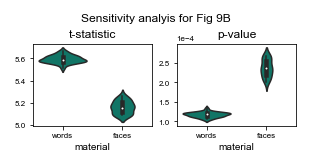

Mean t-statistics:
material
faces    5.162254
words    5.594883
Name: ttest_t, dtype: float64

Mean p-values:
material
faces    0.000237
words    0.000117
Name: ttest_p, dtype: float64


In [214]:
# plot violin plot of ttest stats

# ttest violin plot 
fig, ax = plt.subplots(1, 2, figsize=[4, 2], constrained_layout=True)
# fig.suptitle(f"Sensitivity analyis for t-test (score v. chance)")
fig.suptitle(f"Sensitivity analyis for Fig 9B")

sns.violinplot(data=df_stats_p, x='material', y='ttest_t', ax=ax[0], color=COLORS['blue'])
ax[0].set(ylabel='', title='t-statistic')

sns.violinplot(data=df_stats_p, x='material', y='ttest_p', ax=ax[1], color=COLORS['blue'])
ax[1].set(ylabel='', title='p-value')
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# save/show
# plt.savefig(f"{path_out}/sensitivity_analysis_ttest.png")
plt.show()

# print means
print("Mean t-statistics:")
print(df_stats_p.groupby('material')['ttest_t'].mean())
print("\nMean p-values:")
print(df_stats_p.groupby('material')['ttest_p'].mean())

In [215]:
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=[
    np.array([1,133,113]) / 255, # blue
    np.array([166,97,26]) / 255, # brown
])

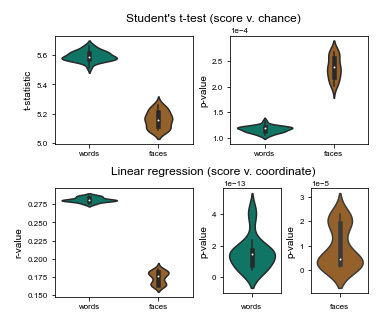

In [217]:
# create figure and gridspec
fig = plt.figure(figsize=[5, 4], constrained_layout=True)
spec = gridspec.GridSpec(figure=fig, ncols=2, nrows=2, width_ratios=[1,1], height_ratios=[1,1])
ax_a = fig.add_subplot(spec[0,0])
ax_b = fig.add_subplot(spec[0,1])
ax_c = fig.add_subplot(spec[1,0])

# create nested gridscpec for subplot d
spec_d = spec[1,1].subgridspec(1,2, width_ratios=[1,1])
ax_d = fig.add_subplot(spec_d[0])
ax_e = fig.add_subplot(spec_d[1])
 
# plot subplot a - ttest t
sns.violinplot(data=df_stats_p, x='material', y='ttest_t', ax=ax_a)
ax_a.set(xlabel='', ylabel='t-statistic', title='')

# plot subplot b - ttest p
sns.violinplot(data=df_stats_p, x='material', y='ttest_p', ax=ax_b)
ax_b.set(xlabel='', ylabel='p-value', title='')
ax_b.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# plot subplot c - regression r
sns.violinplot(data=df_stats, x='material', y='regress_r', ax=ax_c)
ax_c.set(xlabel='', ylabel='r-value', title='\n')

# plot subplot d/e - regression p
for ax, material, color in zip([ax_d, ax_e], ['words', 'faces'], [COLORS['blue'], COLORS['brown']]):
    sns.violinplot(data=df_stats.loc[df_stats['material']==material], y='regress_p', ax=ax, color=color)
    ax.set(ylabel='p-value', title='\n')
    ax.set_xlabel(material, fontsize=8)

# 
fig.text(0.56, 1.02, "Student's t-test (score v. chance)", ha='center', va='center', fontsize=12)
fig.text(0.56, 0.49, 'Linear regression (score v. coordinate)', ha='center', va='center', fontsize=12)

# save/show
fname_out = f"{PROJECT_PATH}/figures/supporting_figures/sensitivity_analysis.png"
plt.savefig(fname_out, bbox_inches='tight')
plt.show()

#### Sensitivity analysis
SpecParam frequency range

In [44]:
# # run logistic regression for all channels in each trial condition

# features_x = ['exponent_diff', 'alpha_diff', 'gamma_diff']
# feature_y = 'recalled'

# # create dataframe to store results (one row for each channel-material pair)
# df = results.groupby(['patient', 'chan_idx', 'material']).mean().reset_index()
# df = df[['patient', 'chan_idx', 'material']]
# df['score'] = np.nan 

# # run logistic regression 
# for i_patient, patient in enumerate(PATIENTS):
#     channels = results.loc[results['patient']==patient, 'chan_idx'].unique()
#     for channel in channels:
#         for i_material, material in enumerate(['words', 'faces']):
#             try: # some patients/channels don't have data
#                 res_i = results.loc[(results['patient']==patient) & \
#                                     (results['chan_idx']==channel) & \
#                                     (results['material']==material)]
#                 clf, score = run_logistic_regression_cv(res_i, features_x, 
#                                                         feature_y)
#                 df_index = (df['patient']==patient) & (df['chan_idx']==channel) & (df['material']==material)
#                 df.loc[df_index, 'score'] = score
#             except:
#                 pass

# df

In [190]:
# save/load results from above
# df.to_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_fullrange.csv", index=False)
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_fullrange.csv")
df

,patient,chan_idx,material,score
0,pat02,0,faces,0.584167
1,pat02,0,words,0.787500
2,pat02,1,faces,0.675000
3,pat02,1,words,0.793382
4,pat02,2,faces,0.649123
...,...,...,...,...
1338,pat22,50,words,0.514737
1339,pat22,51,faces,0.616340
1340,pat22,51,words,0.660526
1341,pat22,52,faces,0.604575


In [191]:
# load regression scores and electrode locations

# load electrode locations
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)

# merge channel info with regression results
df = pd.merge(df, df_elec, on=['patient', 'chan_idx'])
df

,patient,chan_idx,material,score,label,pos_y,pos_x,pos_z
0,pat02,0,faces,0.584167,A01-A02,-65.43100,61.94490,3.55955
1,pat02,0,words,0.787500,A01-A02,-65.43100,61.94490,3.55955
2,pat02,1,faces,0.675000,A02-A03,-70.93895,57.17765,12.15540
3,pat02,1,words,0.793382,A02-A03,-70.93895,57.17765,12.15540
4,pat02,2,faces,0.649123,A03-A04,-75.39550,51.39440,20.94335
...,...,...,...,...,...,...,...,...
1338,pat22,50,words,0.514737,MOF_07-MOF_08,44.50000,-14.00000,16.50000
1339,pat22,51,faces,0.616340,MOF_08-MOF_09,48.00000,-14.00000,23.50000
1340,pat22,51,words,0.660526,MOF_08-MOF_09,48.00000,-14.00000,23.50000
1341,pat22,52,faces,0.604575,MOF_09-MOF_10,52.00000,-14.00000,30.00000


In [195]:
# analyze scores

# run stats
for material in ['words', 'faces']:
    df_m = df.loc[df['material']==material]
    results = analyze_scores(df_m)

    print(f"\n{material} encoding-------------------")
    print(f"mean score:\t{np.nanmean(df_m['score']):0.3f}")
    print(f"t-test (score v. chance):")
    print(f"\tt = {results[0]:0.3f} \n\tp = {results[1]:0.2e}")
    print(f"Regression (score v. AP coordinate):")
    print(f"\tr = {results[2]:0.3f} \n\tp = {results[3]:0.2e}")

# average df over channels within each patient
df_p = df.groupby(['patient', 'material']).mean().reset_index().drop(columns=['chan_idx', 'pos_x', 'pos_y', 'pos_z'])

# re-run with patient averages
print("\n\nPatient averages-------------------------------------")
for material in ['words', 'faces']:
    df_m = df_p.loc[df_p['material']==material]
    results = t, p = ttest_1samp(df_m['score'], 0.5)
    print(f"\n{material} encoding-------------------")
    print(f"mean score:\t{np.nanmean(df_m['score']):0.3f}")
    print(f"t-test (score v. chance):")
    print(f"\tt = {t:0.3f} \n\tp = {p:0.2e}")



words encoding-------------------
mean score:	0.692
t-test (score v. chance):
	t = 36.216 
	p = 1.22e-159
Regression (score v. AP coordinate):
	r = 0.281 
	p = 1.36e-13

faces encoding-------------------
mean score:	0.600
t-test (score v. chance):
	t = 29.541 
	p = 3.25e-123
Regression (score v. AP coordinate):
	r = 0.188 
	p = 9.98e-07


Patient averages-------------------------------------

words encoding-------------------
mean score:	0.689
t-test (score v. chance):
	t = 5.571 
	p = 1.22e-04

faces encoding-------------------
mean score:	0.615
t-test (score v. chance):
	t = 4.981 
	p = 3.19e-04
